In [1]:
# My plan for this project is to perform an EOF analysis on sea ice index data in the Arctic Ocean north of Canada and Alaska.
# Spatial bounds: 75 to 90 N, -175 to -135 W
# Timeframe: 1989 - 2025
# Then, I will look for a correlation with surface (2m) air temperature and reconstructed sea ice data in the same grid, to determine any correlation 
# patterns between sea ice index and surface temperature. 

In [2]:
# Sea ice index was obtained from Copernicus ERA5 Reanalysis data:
# https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=download 
# DOI: 10.7265/a98x-0f50

In [3]:
import numpy as np
import xarray as xr

In [4]:
# Open the netcdf dataset that has been downloaded and saved in this folder:

seaice = xr.open_dataset('sea_ice_cover_reanalysis.nc', engine='h5netcdf')

# Read the dataset to check dims, coords, and variables
seaice

<xarray.Dataset> Size: 530MB
Dimensions:     (valid_time: 13488, latitude: 61, longitude: 161)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 108kB 1989-01-01 ... 2025-12-05
  * latitude    (latitude) float64 488B 90.0 89.75 89.5 ... 75.5 75.25 75.0
  * longitude   (longitude) float64 1kB -175.0 -174.8 -174.5 ... -135.2 -135.0
    expver      (valid_time) <U4 216kB ...
Data variables:
    siconc      (valid_time, latitude, longitude) float32 530MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-10T04:16 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
# The timeframe, latitude, and longitude are all accurate to what was requested. 
# Note that the sea ice index variable is called siconc. 

In [6]:
# Before performing EOF analysis, I need to compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point) and detrending the data. 

# Before deseasonalizing and detrending the data, I will take the monthly average of each month: 

seaice_monthly = seaice["siconc"].resample(valid_time="1MS").mean()

seaice_monthly


<xarray.DataArray 'siconc' (valid_time: 444, latitude: 61, longitude: 161)> Size: 17MB
array([[[0.9943109 , 0.9943109 , 0.9943109 , ..., 0.9943109 ,
         0.9943109 , 0.9943109 ],
        [0.99155354, 0.99155056, 0.99154764, ..., 0.9924641 ,
         0.9924789 , 0.9924966 ],
        [0.9874996 , 0.98750454, 0.98750156, ..., 0.9908674 ,
         0.99089986, 0.99092937],
        ...,
        [0.9997775 , 0.9997303 , 0.999684  , ..., 0.9999124 ,
         0.99987006, 0.9998287 ],
        [0.9997027 , 0.99965346, 0.99958754, ..., 0.9999852 ,
         0.99997735, 0.999934  ],
        [0.9997234 , 0.9995806 , 0.99943984, ..., 0.99986905,
         0.99986315, 0.9998543 ]],

       [[0.9958398 , 0.9958398 , 0.9958398 , ..., 0.9958398 ,
         0.9958398 , 0.9958398 ],
        [0.99312264, 0.99312264, 0.99311936, ..., 0.9940818 ,
         0.9940992 , 0.9941188 ],
        [0.9888099 , 0.9888055 , 0.9888044 , ..., 0.99193466,
         0.9919728 , 0.9920098 ],
...
        [0.9771993 , 0.9774557 , 0.9777151 , ..., 0.9567403 ,
         0.9538656 , 0.9509837 ],
        [0.97095233, 0.9712077 , 0.97177327, ..., 0.9488149 ,
         0.9467051 , 0.9437978 ],
        [0.96880496, 0.9680756 , 0.96734416, ..., 0.9438039 ,
         0.9431488 , 0.9424876 ]],

       [[0.92559814, 0.92559814, 0.92559814, ..., 0.92559814,
         0.92559814, 0.92559814],
        [0.938269  , 0.93825686, 0.9382385 , ..., 0.9357483 ,
         0.9357483 , 0.9357483 ],
        [0.9457825 , 0.94569093, 0.9455994 , ..., 0.9359253 ,
         0.9359314 , 0.9359314 ],
        ...,
        [0.91030276, 0.9123413 , 0.9143921 , ..., 0.95818484,
         0.9555481 , 0.95291746],
        [0.9039246 , 0.9060181 , 0.9097961 , ..., 0.954834  ,
         0.95375365, 0.9510864 ],
        [0.90112305, 0.90601194, 0.910907  , ..., 0.9501709 ,
         0.9495972 , 0.9490417 ]]], shape=(444, 61, 161), dtype=float32)
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 488B 90.0 89.75 89.5 ... 75.5 75.25 75.0
  * longitude   (longitude) float64 1kB -175.0 -174.8 -174.5 ... -135.2 -135.0
  * valid_time  (valid_time) datetime64[ns] 4kB 1989-01-01 ... 2025-12-01
Attributes: (12/31)
    GRIB_paramId:                             31
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      9821
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           ci
    GRIB_units:                               (0 - 1)
    long_name:                                Sea ice area fraction
    units:                                    (0 - 1)
    standard_name:                            sea_ice_area_fraction
    GRIB_surface:                             0.0

In [7]:
# Using the deseasonalizing and detrending code from Module 4 Assignment:

def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z



#seaice_monthly = seaice_monthly.chunk({"valid_time": -1})

detr = linear_detrend(seaice_monthly, time_dim="valid_time")   # siconc is sea ice cover variable

anom, z = monthly_anom_and_z(detr, time_dim="valid_time",
                             base_period=("1989-01-01", "2010-12-01"))  # or None for full-period

print(type(z))
print(z.name)

<class 'xarray.core.dataarray.DataArray'>
None


In [8]:
print(anom)

<xarray.DataArray (valid_time: 444, latitude: 61, longitude: 161)> Size: 17MB
array([[[ 6.2761046e-03,  6.2761046e-03,  6.2761046e-03, ...,
          6.2761046e-03,  6.2761046e-03,  6.2761046e-03],
        [ 3.2432862e-03,  3.2350030e-03,  3.2285172e-03, ...,
          4.0340926e-03,  4.0604211e-03,  4.0901192e-03],
        [-1.1807736e-03, -1.1912212e-03, -1.2086257e-03, ...,
          2.5113570e-03,  2.5587184e-03,  2.6024710e-03],
        ...,
        [-3.0313782e-02, -3.0629314e-02, -3.0943461e-02, ...,
         -2.8928440e-02, -2.7762469e-02, -2.6594143e-02],
        [-3.1889409e-02, -3.2213256e-02, -3.2428265e-02, ...,
         -2.8683957e-02, -2.7474899e-02, -2.6289571e-02],
        [-3.4117550e-02, -3.4296319e-02, -3.4469694e-02, ...,
         -2.8068088e-02, -2.6849750e-02, -2.5635716e-02]],

       [[ 4.0308852e-03,  4.0308852e-03,  4.0308852e-03, ...,
          4.0308852e-03,  4.0308852e-03,  4.0308852e-03],
        [ 5.0867908e-04,  4.9862079e-04,  4.8552081e-04, ...,
     

In [9]:
print(z)

<xarray.DataArray (valid_time: 444, latitude: 61, longitude: 161)> Size: 17MB
array([[[ 0.31325653,  0.31325653,  0.31325653, ...,  0.31325653,
          0.31325653,  0.31325653],
        [ 0.13951755,  0.13919052,  0.13893905, ...,  0.17684487,
          0.17796113,  0.1792368 ],
        [-0.0493654 , -0.04980449, -0.05053169, ...,  0.10001686,
          0.10183474,  0.10350946],
        ...,
        [-0.97937006, -0.9777524 , -0.9755934 , ..., -1.0191991 ,
         -0.99204993, -0.9621751 ],
        [-0.97745824, -0.97489154, -0.97227806, ..., -1.0009173 ,
         -0.97516066, -0.9446762 ],
        [-0.9743804 , -0.9776679 , -0.9803542 , ..., -0.957602  ,
         -0.9327581 , -0.90510195]],

       [[ 0.17374444,  0.17374444,  0.17374444, ...,  0.17374444,
          0.17374444,  0.17374444],
        [ 0.02240902,  0.02198296,  0.02142193, ...,  0.05676632,
          0.05812967,  0.05960407],
        [-0.22403522, -0.2261041 , -0.22798102, ..., -0.05545437,
         -0.05306173, -0.

In [10]:
print(detr)

<xarray.DataArray (valid_time: 444, latitude: 61, longitude: 161)> Size: 17MB
array([[[ 0.02304248,  0.02304248,  0.02304248, ...,  0.02304248,
          0.02304248,  0.02304248],
        [ 0.01940508,  0.01938837,  0.01937165, ...,  0.01892325,
          0.01893349,  0.01894814],
        [ 0.01604595,  0.01601086,  0.0159676 , ...,  0.01639322,
          0.01641683,  0.01643739],
        ...,
        [ 0.07859701,  0.07851802,  0.07843283, ...,  0.03904058,
          0.0397627 ,  0.0404834 ],
        [ 0.08179013,  0.08170388,  0.08200216, ...,  0.04193438,
          0.0427922 ,  0.04352263],
        [ 0.08506647,  0.0854182 ,  0.08576827, ...,  0.04507875,
          0.04597026,  0.0468559 ]],

       [[ 0.0246243 ,  0.0246243 ,  0.0246243 , ...,  0.0246243 ,
          0.0246243 ,  0.0246243 ],
        [ 0.02102905,  0.02101527,  0.02099814, ...,  0.02059063,
          0.02060345,  0.02061996],
        [ 0.01741028,  0.01736577,  0.01732434, ...,  0.01751079,
          0.01754003,  0.

In [11]:
# Now that the monthly average data is detrended and deseasonalized, perform an EOF analysis on the sea ice cover anomalies.

In [12]:
# Import necessary packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from eofs.xarray import Eof
from eofs.examples import example_data_path

In [13]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(detr.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(detr, weights=wgts)

In [14]:
# Retrieve the first 10 EOFs
eof1 = solver.eofsAsCorrelation(neofs=10)
pc1 = solver.pcs(npcs=10, pcscaling=1)

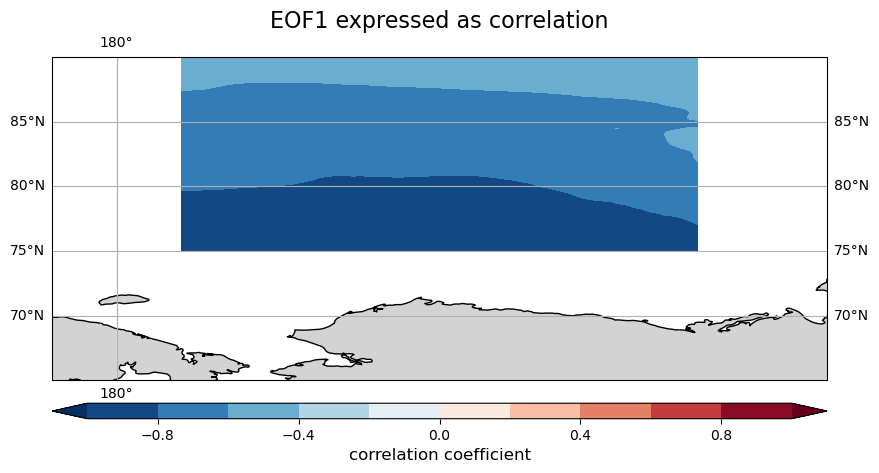

In [15]:
# Plot EOF1 expressed as a correlation

clevs = np.linspace(-1, 1, 11)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=-155))

fill = ax.contourf(eof1.longitude, eof1.latitude, eof1[0].values, levels=clevs, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())

# add coastlines, gridlines, and features
ax.coastlines(resolution='50m', color='black')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# zoom out on the extent to view the nearest coastlines 
ax.set_extent([eof1.longitude.min()-10, eof1.longitude.max()+10,
               eof1.latitude.min()-10, eof1.latitude.max()+10], crs=ccrs.PlateCarree())

# add colorbar
cb = fig.colorbar(fill, orientation='horizontal', pad=0.05, aspect=50)
cb.set_label('correlation coefficient', fontsize=12)

ax.set_title('EOF1 expressed as correlation', fontsize=16)

plt.show()

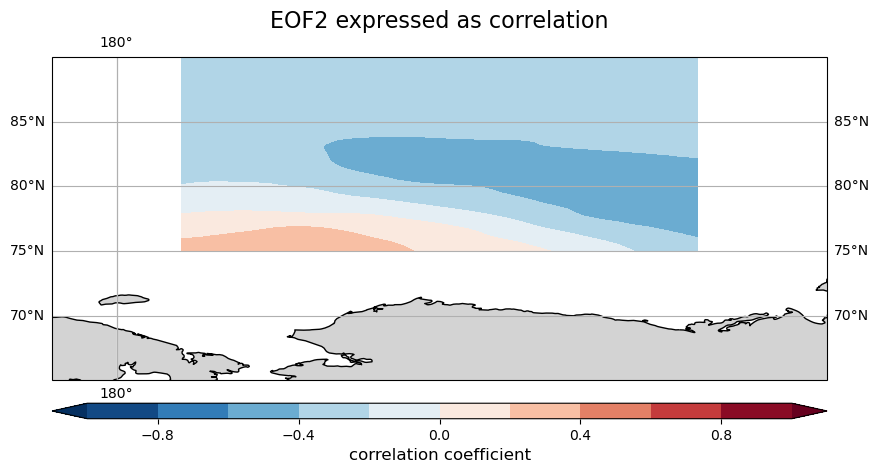

In [16]:
# Plot EOF2 expressed as a correlation

clevs = np.linspace(-1, 1, 11)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=-155))

fill = ax.contourf(eof1.longitude, eof1.latitude, eof1[1].values, levels=clevs, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())

# add coastlines, gridlines, and features
ax.coastlines(resolution='50m', color='black')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# zoom out on the extent to view the nearest coastlines 
ax.set_extent([eof1.longitude.min()-10, eof1.longitude.max()+10,
               eof1.latitude.min()-10, eof1.latitude.max()+10], crs=ccrs.PlateCarree())

# add colorbar
cb = fig.colorbar(fill, orientation='horizontal', pad=0.05, aspect=50)
cb.set_label('correlation coefficient', fontsize=12)

ax.set_title('EOF2 expressed as correlation', fontsize=16)

plt.show()

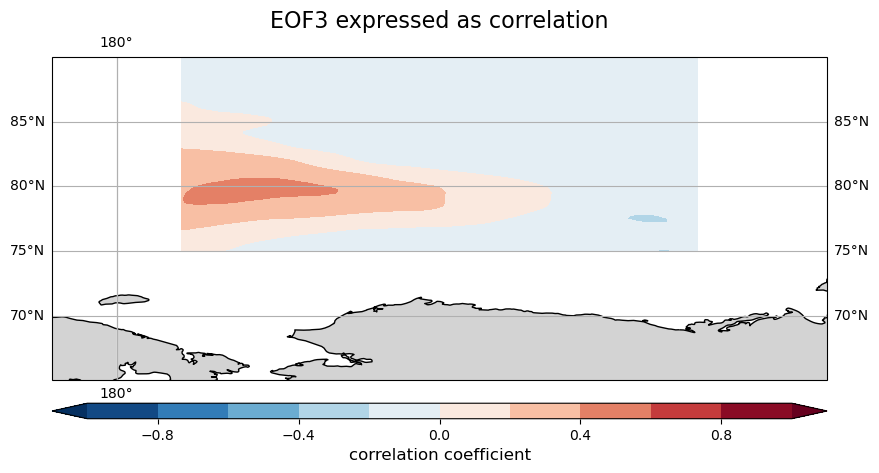

In [17]:
# Plot EOF3 expressed as a correlation

clevs = np.linspace(-1, 1, 11)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=-155))

fill = ax.contourf(eof1.longitude, eof1.latitude, eof1[2].values, levels=clevs, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())

# add coastlines, gridlines, and features
ax.coastlines(resolution='50m', color='black')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# zoom out on the extent to view the nearest coastlines 
ax.set_extent([eof1.longitude.min()-10, eof1.longitude.max()+10,
               eof1.latitude.min()-10, eof1.latitude.max()+10], crs=ccrs.PlateCarree())

# add colorbar
cb = fig.colorbar(fill, orientation='horizontal', pad=0.05, aspect=50)
cb.set_label('correlation coefficient', fontsize=12)

ax.set_title('EOF3 expressed as correlation', fontsize=16)

plt.show()

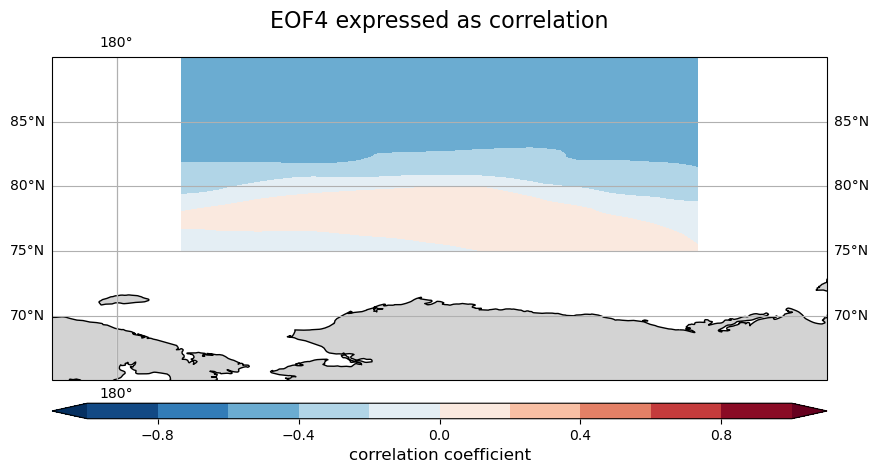

In [18]:
# Plot EOF4 expressed as a correlation

clevs = np.linspace(-1, 1, 11)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=-155))

fill = ax.contourf(eof1.longitude, eof1.latitude, eof1[3].values, levels=clevs, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())

# add coastlines, gridlines, and features
ax.coastlines(resolution='50m', color='black')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# zoom out on the extent to view the nearest coastlines 
ax.set_extent([eof1.longitude.min()-10, eof1.longitude.max()+10,
               eof1.latitude.min()-10, eof1.latitude.max()+10], crs=ccrs.PlateCarree())

# add colorbar
cb = fig.colorbar(fill, orientation='horizontal', pad=0.05, aspect=50)
cb.set_label('correlation coefficient', fontsize=12)

ax.set_title('EOF4 expressed as correlation', fontsize=16)

plt.show()

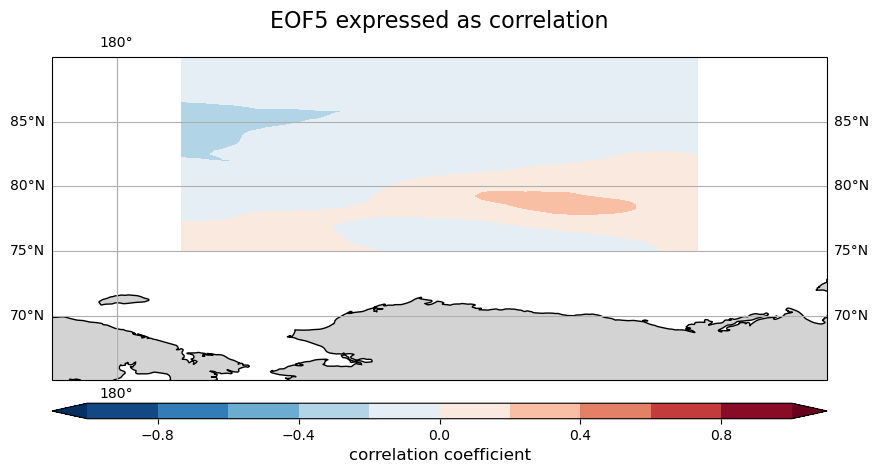

In [19]:
# Plot EOF5 expressed as a correlation

clevs = np.linspace(-1, 1, 11)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=-155))

fill = ax.contourf(eof1.longitude, eof1.latitude, eof1[4].values, levels=clevs, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())

# add coastlines, gridlines, and features
ax.coastlines(resolution='50m', color='black')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# zoom out on the extent to view the nearest coastlines 
ax.set_extent([eof1.longitude.min()-10, eof1.longitude.max()+10,
               eof1.latitude.min()-10, eof1.latitude.max()+10], crs=ccrs.PlateCarree())

# add colorbar
cb = fig.colorbar(fill, orientation='horizontal', pad=0.05, aspect=50)
cb.set_label('correlation coefficient', fontsize=12)

ax.set_title('EOF5 expressed as correlation', fontsize=16)

plt.show()

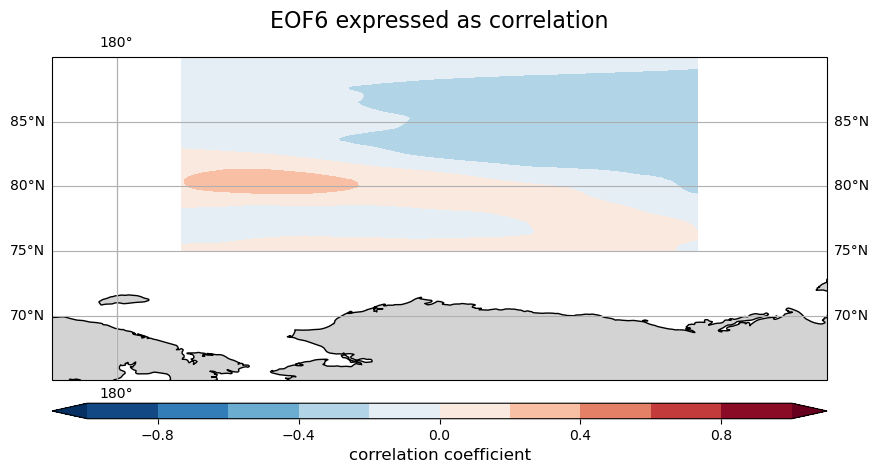

In [20]:
# Plot EOF6 expressed as a correlation

clevs = np.linspace(-1, 1, 11)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=-155))

fill = ax.contourf(eof1.longitude, eof1.latitude, eof1[5].values, levels=clevs, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())

# add coastlines, gridlines, and features
ax.coastlines(resolution='50m', color='black')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# zoom out on the extent to view the nearest coastlines 
ax.set_extent([eof1.longitude.min()-10, eof1.longitude.max()+10,
               eof1.latitude.min()-10, eof1.latitude.max()+10], crs=ccrs.PlateCarree())

# add colorbar
cb = fig.colorbar(fill, orientation='horizontal', pad=0.05, aspect=50)
cb.set_label('correlation coefficient', fontsize=12)

ax.set_title('EOF6 expressed as correlation', fontsize=16)

plt.show()

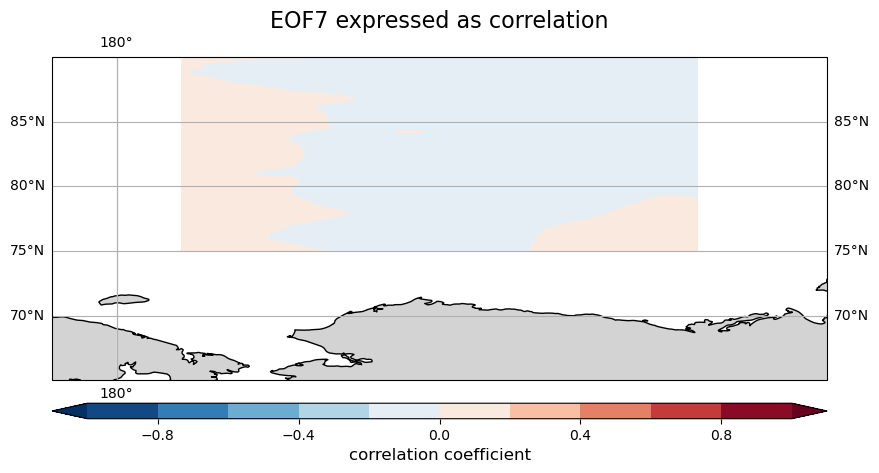

In [21]:
# Plot EOF7 expressed as a correlation

clevs = np.linspace(-1, 1, 11)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=-155))

fill = ax.contourf(eof1.longitude, eof1.latitude, eof1[6].values, levels=clevs, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())

# add coastlines, gridlines, and features
ax.coastlines(resolution='50m', color='black')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# zoom out on the extent to view the nearest coastlines 
ax.set_extent([eof1.longitude.min()-10, eof1.longitude.max()+10,
               eof1.latitude.min()-10, eof1.latitude.max()+10], crs=ccrs.PlateCarree())

# add colorbar
cb = fig.colorbar(fill, orientation='horizontal', pad=0.05, aspect=50)
cb.set_label('correlation coefficient', fontsize=12)

ax.set_title('EOF7 expressed as correlation', fontsize=16)

plt.show()

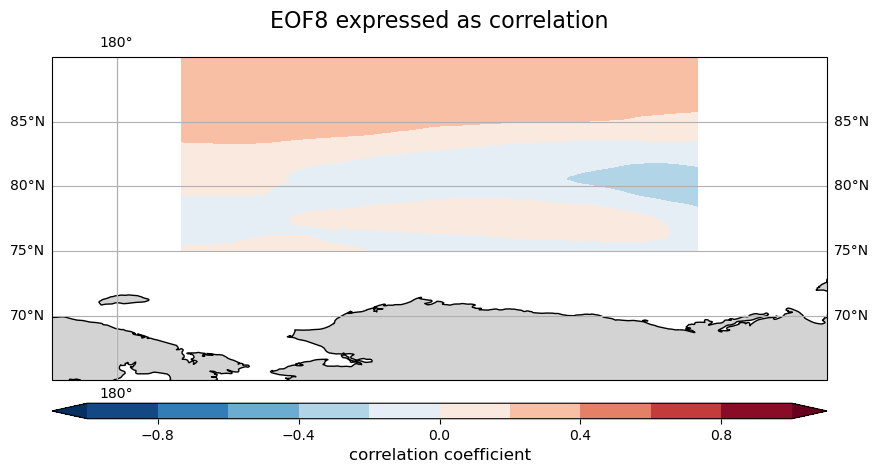

In [22]:
# Plot EOF8 expressed as a correlation

clevs = np.linspace(-1, 1, 11)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=-155))

fill = ax.contourf(eof1.longitude, eof1.latitude, eof1[7].values, levels=clevs, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())

# add coastlines, gridlines, and features
ax.coastlines(resolution='50m', color='black')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# zoom out on the extent to view the nearest coastlines 
ax.set_extent([eof1.longitude.min()-10, eof1.longitude.max()+10,
               eof1.latitude.min()-10, eof1.latitude.max()+10], crs=ccrs.PlateCarree())

# add colorbar
cb = fig.colorbar(fill, orientation='horizontal', pad=0.05, aspect=50)
cb.set_label('correlation coefficient', fontsize=12)

ax.set_title('EOF8 expressed as correlation', fontsize=16)

plt.show()

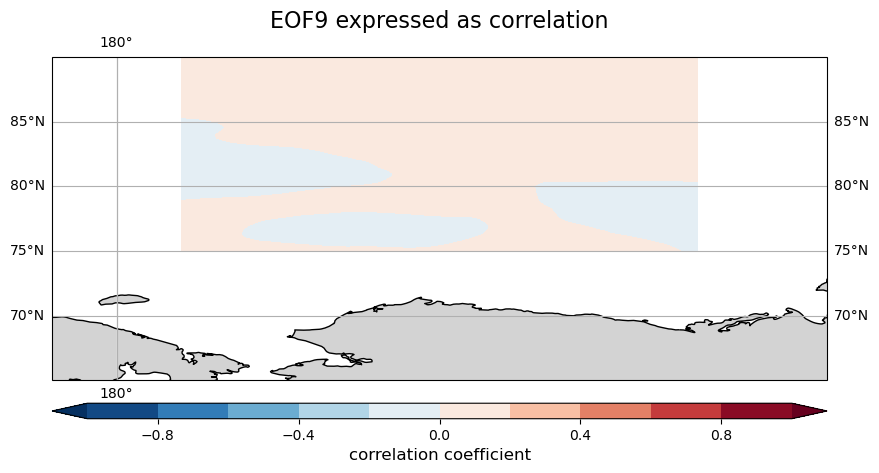

In [23]:
# Plot EOF9 expressed as a correlation

clevs = np.linspace(-1, 1, 11)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=-155))

fill = ax.contourf(eof1.longitude, eof1.latitude, eof1[8].values, levels=clevs, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())

# add coastlines, gridlines, and features
ax.coastlines(resolution='50m', color='black')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# zoom out on the extent to view the nearest coastlines 
ax.set_extent([eof1.longitude.min()-10, eof1.longitude.max()+10,
               eof1.latitude.min()-10, eof1.latitude.max()+10], crs=ccrs.PlateCarree())

# add colorbar
cb = fig.colorbar(fill, orientation='horizontal', pad=0.05, aspect=50)
cb.set_label('correlation coefficient', fontsize=12)

ax.set_title('EOF9 expressed as correlation', fontsize=16)

plt.show()

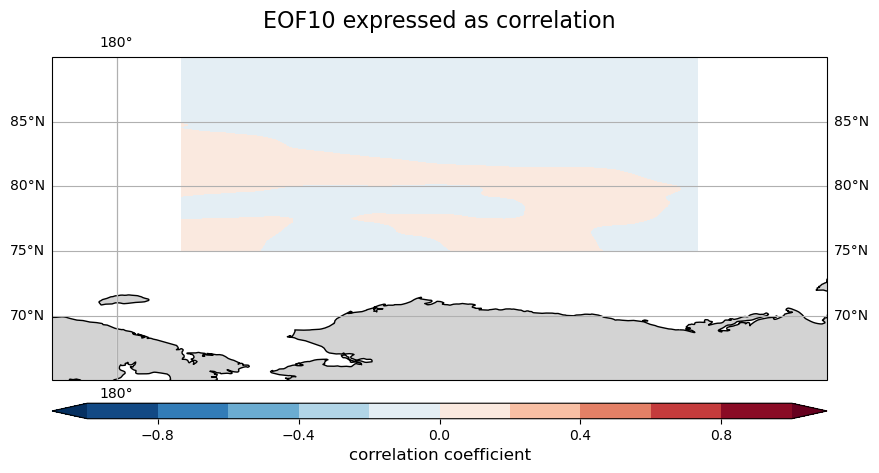

In [24]:
# Plot EOF10 expressed as a correlation

clevs = np.linspace(-1, 1, 11)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=-155))

fill = ax.contourf(eof1.longitude, eof1.latitude, eof1[9].values, levels=clevs, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())

# add coastlines, gridlines, and features
ax.coastlines(resolution='50m', color='black')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# zoom out on the extent to view the nearest coastlines 
ax.set_extent([eof1.longitude.min()-10, eof1.longitude.max()+10,
               eof1.latitude.min()-10, eof1.latitude.max()+10], crs=ccrs.PlateCarree())

# add colorbar
cb = fig.colorbar(fill, orientation='horizontal', pad=0.05, aspect=50)
cb.set_label('correlation coefficient', fontsize=12)

ax.set_title('EOF10 expressed as correlation', fontsize=16)

plt.show()

In [25]:
# Plot the percent of variance explained by the first 5 EOFs
# Run the variance fraction over a range
varfrac = solver.varianceFraction()

(2.0269569565328087e-17, 0.8523675203323364)

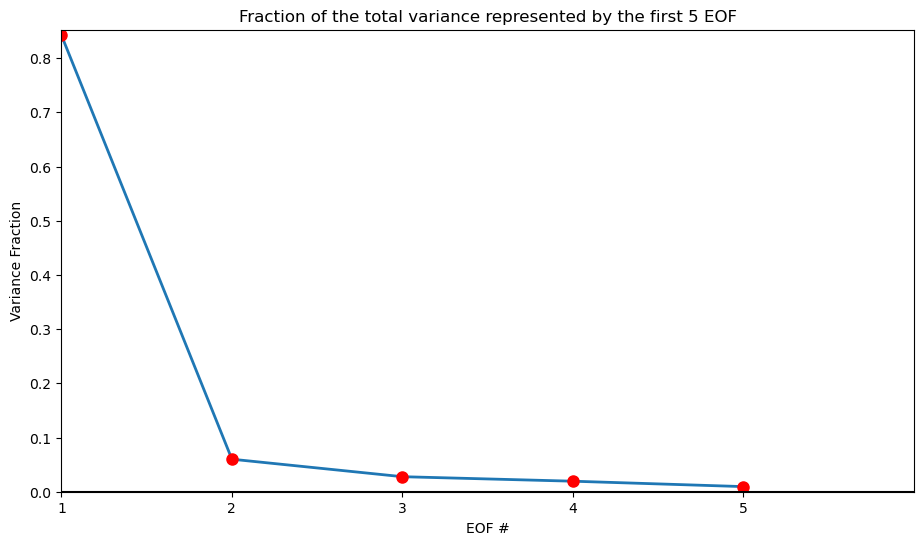

In [26]:
# Plot the fraction of variance explained by each EOF
plt.figure(figsize=(11,6))
eof_num = range(1, 6)
plt.plot(eof_num, varfrac[0:5], linewidth=2)
plt.plot(eof_num, varfrac[0:5], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 6))
plt.title('Fraction of the total variance represented by the first 5 EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 6)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

In [27]:
# Reconstruct sea ice index using the first EOF
reconstruction = solver.reconstructedField(1)
reconstruction

<xarray.DataArray (valid_time: 444, latitude: 61, longitude: 161)> Size: 17MB
array([[[0.00576007, 0.00576005, 0.00576007, ..., 0.00576007,
         0.00576007, 0.00576007],
        [0.00586986, 0.00586435, 0.00585887, ..., 0.00533649,
         0.0053334 , 0.00533029],
        [0.0059063 , 0.00589469, 0.00588303, ..., 0.00517462,
         0.00517204, 0.0051695 ],
        ...,
        [0.05035748, 0.05041998, 0.05048143, ..., 0.0336353 ,
         0.03308169, 0.03252696],
        [0.05150909, 0.0515729 , 0.05162705, ..., 0.03439592,
         0.03385215, 0.03328867],
        [0.05273967, 0.05278429, 0.05282747, ..., 0.03505309,
         0.03447024, 0.03388678]],

       [[0.00185262, 0.00185261, 0.00185262, ..., 0.00185262,
         0.00185262, 0.00185262],
        [0.00188793, 0.00188616, 0.0018844 , ..., 0.00171638,
         0.00171539, 0.00171439],
        [0.00189965, 0.00189592, 0.00189217, ..., 0.00166432,
         0.00166349, 0.00166267],
...
        [0.24508767, 0.24539185, 0.24569094, ..., 0.16370152,
         0.16100715, 0.1583073 ],
        [0.25069246, 0.2510031 , 0.25126663, ..., 0.16740346,
         0.16475692, 0.16201448],
        [0.25668168, 0.25689882, 0.25710896, ..., 0.17060183,
         0.16776517, 0.16492547]],

       [[0.02748531, 0.02748525, 0.02748534, ..., 0.02748532,
         0.02748532, 0.02748532],
        [0.02800922, 0.02798291, 0.02795676, ..., 0.02546414,
         0.0254494 , 0.02543457],
        [0.02818309, 0.02812772, 0.02807208, ..., 0.02469173,
         0.02467943, 0.02466729],
        ...,
        [0.24029087, 0.24058908, 0.24088232, ..., 0.16049759,
         0.15785594, 0.15520895],
        [0.24578597, 0.24609049, 0.24634887, ..., 0.16412708,
         0.16153233, 0.15884356],
        [0.25165796, 0.25187084, 0.25207686, ..., 0.16726284,
         0.16448171, 0.16169758]]], shape=(444, 61, 161), dtype=float32)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 1989-01-01 ... 2025-12-01
  * latitude    (latitude) float64 488B 90.0 89.75 89.5 ... 75.5 75.25 75.0
  * longitude   (longitude) float64 1kB -175.0 -174.8 -174.5 ... -135.2 -135.0
Attributes:
    long_name:  None_reconstructed_with_1_EOFs

In [28]:
# I downloaded daily surface air temperature (2m) from Copernicus as well: 
# https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=download 
# DOI: 10.7265/a98x-0f50
# Data is for the same latitude and longitude parameters, and same timeframe (1989-2025)
# Data is daily and will need the monthly average taken. 

In [29]:
# Open the netcdf dataset that has been downloaded and saved in this folder:

temp = xr.open_dataset('2m_temp.nc', engine='h5netcdf')

# Read the dataset to check dims, coords, and variables
temp

<xarray.Dataset> Size: 530MB
Dimensions:     (valid_time: 13488, latitude: 61, longitude: 161)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 108kB 1989-01-01 ... 2025-12-05
  * latitude    (latitude) float64 488B 90.0 89.75 89.5 ... 75.5 75.25 75.0
  * longitude   (longitude) float64 1kB -175.0 -174.8 -174.5 ... -135.2 -135.0
    expver      (valid_time) <U4 216kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 530MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-10T07:07 GRIB to CDM+CF via cfgrib-0.9.1...

In [30]:
# The timeframe, latitude, and longitude are all accurate to what was requested. 
# Note that the temperature variable is called t2m. 

In [31]:
# Before deseasonalizing and detrending the data, I will take the monthly average of each month: 

temp_monthly = temp["t2m"].resample(valid_time="1MS").mean()

temp_monthly

<xarray.DataArray 't2m' (valid_time: 444, latitude: 61, longitude: 161)> Size: 17MB
array([[[244.01297, 244.01297, 244.01297, ..., 244.01297, 244.01297,
         244.01297],
        [244.31136, 244.31154, 244.3118 , ..., 244.23871, 244.2377 ,
         244.23631],
        [244.58415, 244.58371, 244.58315, ..., 244.3891 , 244.38664,
         244.38419],
        ...,
        [244.56583, 244.59027, 244.61453, ..., 242.12114, 242.07634,
         242.03162],
        [244.72874, 244.75345, 244.75143, ..., 242.17192, 242.11906,
         242.07332],
        [244.80965, 244.8288 , 244.84789, ..., 242.28136, 242.22063,
         242.15958]],

       [[247.38557, 247.38557, 247.38557, ..., 247.38557, 247.38557,
         247.38557],
        [247.45749, 247.45749, 247.45798, ..., 247.4346 , 247.43446,
         247.43433],
        [247.62231, 247.62169, 247.62161, ..., 247.51175, 247.51077,
         247.50993],
...
        [256.3847 , 256.39642, 256.40836, ..., 257.5776 , 257.58752,
         257.59735],
        [256.5993 , 256.61136, 256.61774, ..., 257.7088 , 257.7165 ,
         257.7265 ],
        [256.77325, 256.8021 , 256.83133, ..., 257.8376 , 257.8435 ,
         257.84885]],

       [[257.51642, 257.51642, 257.51642, ..., 257.51642, 257.51642,
         257.51642],
        [257.38516, 257.38477, 257.38477, ..., 257.43906, 257.43906,
         257.43945],
        [257.06796, 257.06915, 257.06915, ..., 257.2453 , 257.2461 ,
         257.24725],
        ...,
        [251.86093, 251.89023, 251.91992, ..., 252.43399, 252.41953,
         252.4043 ],
        [252.01367, 252.04414, 252.075  , ..., 252.63046, 252.61719,
         252.60196],
        [252.09062, 252.11758, 252.14531, ..., 252.7629 , 252.73633,
         252.70976]]], shape=(444, 61, 161), dtype=float32)
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 488B 90.0 89.75 89.5 ... 75.5 75.25 75.0
  * longitude   (longitude) float64 1kB -175.0 -174.8 -174.5 ... -135.2 -135.0
  * valid_time  (valid_time) datetime64[ns] 4kB 1989-01-01 ... 2025-12-01
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      9821
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [37]:
# Using the deseasonalizing and detrending code from Module 4 Assignment:

def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z


detr_temp = linear_detrend(temp_monthly, time_dim="valid_time") 

anom_temp, z_temp = monthly_anom_and_z(detr_temp, time_dim="valid_time",
                             base_period=("1989-01-01", "2010-12-01"))  # or None for full-period

print(type(z_temp))
print(z_temp.name)

<class 'xarray.core.dataarray.DataArray'>
None


In [38]:
# Compute the Pearson's correlation coefficient for the sea ice reconstruction and the detrended, deseasonalized temp data

seaice_corr_EOF1 = xr.corr(reconstruction, detr_temp, dim='valid_time')

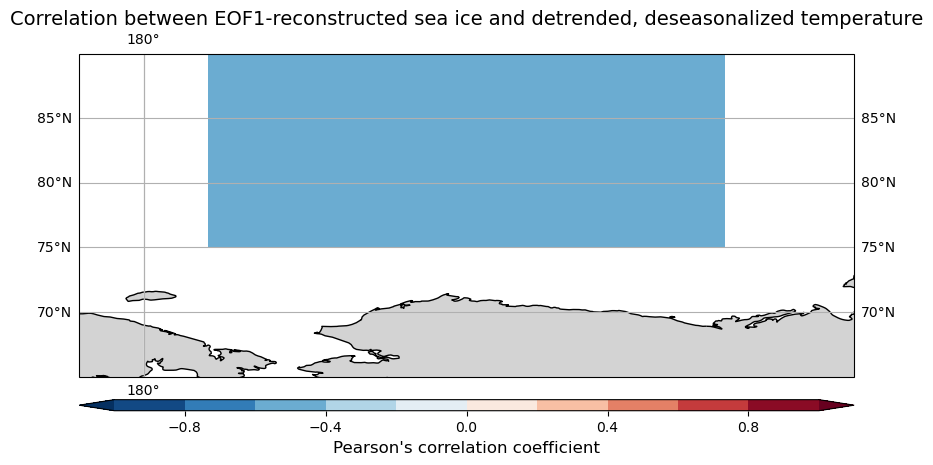

In [39]:
clevs = np.linspace(-1, 1, 11)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=-155))

# plot correlation 
fill = ax.contourf(seaice_corr_EOF1.longitude, seaice_corr_EOF1.latitude, seaice_corr_EOF1.values, levels=clevs, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())

# add coastlines, gridlines, and features
ax.coastlines(resolution='50m', color='black')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# zoom out on the extent to view the nearest coastlines 
ax.set_extent([
    seaice_corr_EOF1.longitude.min()-10, seaice_corr_EOF1.longitude.max()+10,
    seaice_corr_EOF1.latitude.min()-10, seaice_corr_EOF1.latitude.max()+10
], crs=ccrs.PlateCarree())

# add colorbar
cb = fig.colorbar(fill, orientation='horizontal', pad=0.05, aspect=70)
cb.set_label("Pearson's correlation coefficient", fontsize=12)

ax.set_title("Correlation between EOF1-reconstructed sea ice and detrended, deseasonalized temperature", fontsize=14)

plt.show()

In [40]:
# The plot shows the entire lat/lon grid as having the same significance. 

In [41]:
reconstruction

<xarray.DataArray (valid_time: 444, latitude: 61, longitude: 161)> Size: 17MB
array([[[0.00576007, 0.00576005, 0.00576007, ..., 0.00576007,
         0.00576007, 0.00576007],
        [0.00586986, 0.00586435, 0.00585887, ..., 0.00533649,
         0.0053334 , 0.00533029],
        [0.0059063 , 0.00589469, 0.00588303, ..., 0.00517462,
         0.00517204, 0.0051695 ],
        ...,
        [0.05035748, 0.05041998, 0.05048143, ..., 0.0336353 ,
         0.03308169, 0.03252696],
        [0.05150909, 0.0515729 , 0.05162705, ..., 0.03439592,
         0.03385215, 0.03328867],
        [0.05273967, 0.05278429, 0.05282747, ..., 0.03505309,
         0.03447024, 0.03388678]],

       [[0.00185262, 0.00185261, 0.00185262, ..., 0.00185262,
         0.00185262, 0.00185262],
        [0.00188793, 0.00188616, 0.0018844 , ..., 0.00171638,
         0.00171539, 0.00171439],
        [0.00189965, 0.00189592, 0.00189217, ..., 0.00166432,
         0.00166349, 0.00166267],
...
        [0.24508767, 0.24539185, 0.24569094, ..., 0.16370152,
         0.16100715, 0.1583073 ],
        [0.25069246, 0.2510031 , 0.25126663, ..., 0.16740346,
         0.16475692, 0.16201448],
        [0.25668168, 0.25689882, 0.25710896, ..., 0.17060183,
         0.16776517, 0.16492547]],

       [[0.02748531, 0.02748525, 0.02748534, ..., 0.02748532,
         0.02748532, 0.02748532],
        [0.02800922, 0.02798291, 0.02795676, ..., 0.02546414,
         0.0254494 , 0.02543457],
        [0.02818309, 0.02812772, 0.02807208, ..., 0.02469173,
         0.02467943, 0.02466729],
        ...,
        [0.24029087, 0.24058908, 0.24088232, ..., 0.16049759,
         0.15785594, 0.15520895],
        [0.24578597, 0.24609049, 0.24634887, ..., 0.16412708,
         0.16153233, 0.15884356],
        [0.25165796, 0.25187084, 0.25207686, ..., 0.16726284,
         0.16448171, 0.16169758]]], shape=(444, 61, 161), dtype=float32)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 1989-01-01 ... 2025-12-01
  * latitude    (latitude) float64 488B 90.0 89.75 89.5 ... 75.5 75.25 75.0
  * longitude   (longitude) float64 1kB -175.0 -174.8 -174.5 ... -135.2 -135.0
Attributes:
    long_name:  None_reconstructed_with_1_EOFs

In [42]:
detr_temp

<xarray.DataArray (valid_time: 444, latitude: 61, longitude: 161)> Size: 17MB
array([[[-14.168596  , -14.168596  , -14.168596  , ..., -14.168596  ,
         -14.168596  , -14.168596  ],
        [-13.825351  , -13.825339  , -13.825089  , ..., -13.896456  ,
         -13.897446  , -13.898776  ],
        [-13.555415  , -13.555296  , -13.555471  , ..., -13.687126  ,
         -13.689815  , -13.692199  ],
        ...,
        [-15.212541  , -15.184024  , -15.155497  , ..., -16.912374  ,
         -16.956892  , -17.001219  ],
        [-15.181486  , -15.152656  , -15.145063  , ..., -16.955486  ,
         -17.007763  , -17.05338   ],
        [-15.227976  , -15.203533  , -15.178834  , ..., -16.961582  ,
         -17.022211  , -17.08322   ]],

       [[-10.802553  , -10.802553  , -10.802553  , ..., -10.802553  ,
         -10.802553  , -10.802553  ],
        [-10.68583   , -10.686001  , -10.685522  , ..., -10.707108  ,
         -10.707227  , -10.707307  ],
        [-10.52386   , -10.523923  , -10.52361   , ..., -10.570991  ,
         -10.572199  , -10.572965  ],
...
          -3.7043245 ,  -3.6820421 ],
        [ -6.7214155 ,  -6.7191343 ,  -6.7170234 , ...,  -3.6685774 ,
          -3.6464832 ,  -3.6240551 ],
        [ -6.6516294 ,  -6.6309843 ,  -6.609589  , ...,  -3.61959   ,
          -3.6011012 ,  -3.583318  ]],

       [[ -3.5185428 ,  -3.5185428 ,  -3.5185428 , ...,  -3.5185428 ,
          -3.5185428 ,  -3.5185428 ],
        [ -3.6277056 ,  -3.6280532 ,  -3.6277988 , ...,  -3.5423915 ,
          -3.5422263 ,  -3.5415819 ],
        [ -3.9452786 ,  -3.943186  ,  -3.942476  , ...,  -3.6644707 ,
          -3.663567  ,  -3.6619308 ],
        ...,
        [-11.355119  , -11.335511  , -11.315272  , ...,  -8.875249  ,
          -8.87736   ,  -8.880106  ],
        [-11.314653  , -11.293985  , -11.26743   , ...,  -8.751933  ,
          -8.750774  ,  -8.753556  ],
        [-11.341815  , -11.323077  , -11.303223  , ...,  -8.69922   ,
          -8.713189  ,  -8.727284  ]]],
      shape=(444, 61, 161), dtype=float32)
Coordinates:
    number      int64 8B 0
  * latitude    (latitude) float64 488B 90.0 89.75 89.5 ... 75.5 75.25 75.0
  * longitude   (longitude) float64 1kB -175.0 -174.8 -174.5 ... -135.2 -135.0
  * valid_time  (valid_time) datetime64[ns] 4kB 1989-01-01 ... 2025-12-01

In [44]:
print(reconstruction.dims)
print(detr_temp.dims)

('valid_time', 'latitude', 'longitude')
('valid_time', 'latitude', 'longitude')
